The model could be improved with the following:

- Use one-hot representation on only the drug name and a different reprenstation describing the unit (mg/g) and another representation for number of grams/mg

- you could normalize the number of grams/mg to be all from 0 to 1

- retrain (or train from scratch) on  a lot of data containing alot of the similar names like panadol and pandol extra (hard negative mining)
. same thing with english names.

- instead of using the l2 norm between the two vectors as an input, use the difference of the two vectors. And let the NN learn a weighted sum.

In [1]:
!pip install fuzzywuzzy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, Softmax, Reshape, Embedding
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda, Masking, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from fuzzywuzzy import fuzz, process

/usr/local/lib/python3.11/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [8]:
# sku 307 is not in the dataset file
data = pd.read_excel("data.xlsx", sheet_name="Dataset")
target = pd.read_excel("data.xlsx", sheet_name="Master File")

In [9]:
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sku              1000 non-null   int64  
 1   product_name     1000 non-null   object 
 2   product_name_ar  1000 non-null   object 
 3   price            1000 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 31.4+ KB


In [10]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83562 entries, 0 to 83561
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sku                          83562 non-null  int64  
 1   marketplace_product_name_ar  83562 non-null  object 
 2   seller_item_name             83562 non-null  object 
 3   price                        83562 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.6+ MB
None


In [11]:
seller_item_name = data["seller_item_name"]
sku_values = data["sku"]


4171
41606


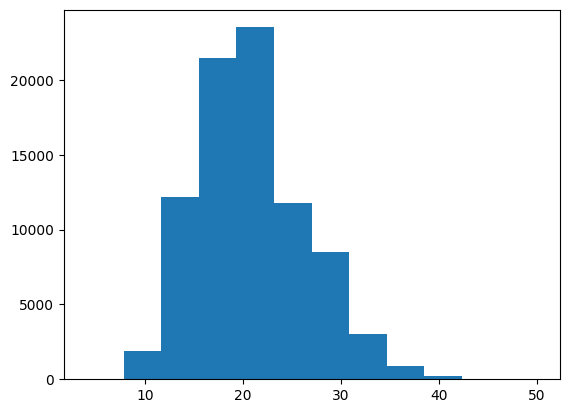

In [12]:
# the input sequence will be 30

lengths = np.array([len(sen) for sen in seller_item_name])

print(np.sum(lengths > 30))

print(np.sum(lengths > 20))

plt.hist(lengths, bins=12)

Tx = 30

In [13]:
arabic_char = list("اﻷإﻹأآءئبتثجحخدذرزسشصضطظعغفقكلمنهويىة")
english_char = list("abcdefghijklmnopqrstuvwxyz")
symbols = list(".%/")
numbers = [str(num) for num in range(10)]
# arabic + symbols + english + numbers

# mapping characters to indices
index_to_char = {}
char_to_index = {}
for i, char in enumerate(arabic_char + symbols + english_char + numbers):
  index_to_char.update({i: char })
  char_to_index.update({char: i})

vocab_size = len(index_to_char)
print(max(seller_item_name, key=len))


بولي فريش اكسترا قطرة عين احادي الجرعة 30 * 0.4 مل


In [14]:
def apply_regex(sentence):
  """
  apply regex on a string and return new one
  """
  new = re.sub(r"[^a-zA-Z0-9%\.\u0600-\u06FF\s]", " ", sentence)
  # remove tatweel symbol
  new = re.sub(r"\u0640", "" , new)
  # remove tashkeel
  new = re.sub(r"[\u064B-\u0652]", "", new)
  # remove arabic punctuation
  new = re.sub(r"[،؛؟“”‘’•]", "", new)
  # remove extra spaces
  new = re.sub(r"^\s+|\s+$|\s{2,}", " ", new).strip()
  new = re.sub(r"^\s+", " ", new)
  return new


In [15]:
def pre_process_strings(x, Tx, char_to_index, pad_value= -1):
  """
  x: array of strings
  Tx: sequence length
  char_to_index: a dict mapping characters to indices
  pad_value : the value to use in padding

  Processes a list of strings by applying regex then mapping the chars to indices

  Returns:
    indices: shape(x.shape[0], Tx)
  """

  if isinstance(x, (pd.DataFrame, pd.Series)):
    x = x.values

  x = x.copy()
  for i, sentence in enumerate(x):
    x[i] = apply_regex(sentence)

  indices = np.full((len(x), Tx), pad_value)
  for i, sentence in enumerate(x):
    chars = list(sentence)
    for j, char in enumerate(chars):
      char = char.lower()
      # remove whitespace
      if char == ' ':
        continue
      if j < Tx:
        if char in char_to_index:
          indices[i, j] = char_to_index[char]


  return indices



In [16]:
def pre_process_dataset_training(X, Y,Tx, char_to_index, unique_classes = 500, sample_per_categ = 200 , negative_samples_ratio=0.5):
  """
  X: array of input strings (samples) of shape(m,) | where m is number of samples
  Y: array of target strings of shape (m,) | where m is number of samples
  Tx: sequence length
  char_to_index: a dict mapping all characters in vocab to their indices (0 to vocab_size)
  unique_classes: number of unqiue classes in the dataset
  sample_per_categ: is the number of positive and negative samples (combined) for each sample
  negative_samples_ratio: ratio of negative to postive samples

  returns 'sample_per_categ' positve and negative samples for each sample
  for negative samples randomly choose another class

  new_X: shape(n, 2, Tx)
  new_y: shape(n,)
  n is the new number of samples , which could be different that the original (m)
  n = sample_per_categ * unique_classes
  """

  X = X.copy()
  Y = Y.copy()

  # -1 for padded values
  indices_X = pre_process_strings(X, Tx, char_to_index)
  indices_y = pre_process_strings(Y, Tx, char_to_index)

  start_new_category = []
  for i, sentence in enumerate(Y):
    # maintain the starting index of a new category
    if i == 0:
      start_new_category.append(i)
    else:
      if Y[i] != Y[i - 1]:
        start_new_category.append(i)

  print(start_new_category)

  # make positive and negative samples
  n = (sample_per_categ * unique_classes)
  new_X = np.zeros((n, 2, Tx))
  new_y = np.full((n,), -1)

  num_positive_samples = int(sample_per_categ * (1 - negative_samples_ratio))
  num_negative_samples =  int(sample_per_categ * negative_samples_ratio)

  # positive samples
  for i in range(unique_classes): # 0 to 499
    for j in range(num_positive_samples): # 0 to 239

      first_index = start_new_category[i]
      # last category
      if i == len(start_new_category) - 1:
        last_index = len(X)
      else:
        last_index = start_new_category[i + 1] - 1

      # index for indices_X and indices_y
      index = np.random.randint(first_index, last_index, size = 1)

      # positive sample
      new_X[int(j + (i * sample_per_categ * (1 - negative_samples_ratio))) , 0, :] = indices_X[index, :]
      new_X[int(j + (i * sample_per_categ * (1 - negative_samples_ratio))) , 1, :] = indices_y[index, :]
      new_y[int(j + (i * sample_per_categ * (1 - negative_samples_ratio)))] = 1


  # starting index
  start = unique_classes * (sample_per_categ * (1 - negative_samples_ratio))
  # negative samples
  for i in range(unique_classes): # 0 to 499
    for j in range(num_negative_samples): # 0 to 239

      first_index = start_new_category[i]
      # last category
      if i == len(start_new_category) - 1:
        last_index = len(X)
      else:
        last_index = start_new_category[i + 1] - 1


      # index for indices_X and indices_y
      # choose index from current category
      index = np.random.randint(first_index, last_index, size = 1)

      # random index for negative samples (not similar)
      rand_index = np.random.randint(low= 0, high= X.shape[0], size=1)[0]
      # if the random index is the same category as current category, get another index
      while rand_index >= first_index and rand_index < last_index:
        rand_index = np.random.randint(low= 0, high= X.shape[0], size=1)[0]


      # negative sample
      new_X[int(j + start + (i * sample_per_categ * negative_samples_ratio)) , 0, :] = indices_X[index, :]
      new_X[int(j + start + (i * sample_per_categ * negative_samples_ratio)) , 1, :] = indices_y[rand_index, :]
      new_y[int(j + start + (i * sample_per_categ * negative_samples_ratio))] = 0



  return new_X[new_y != -1], new_y[new_y != -1]


In [17]:
def pre_process_input(sentence1, sentence2, Tx, char_to_index):
  """
  sentence1: string
  sentence2: string
  Tx: sequence length
  char_to_index: a dict mapping all characters in vocab to their indices (0 to vocab_size)

  Returns:
    x: shape(1, 2, Tx, len(char_to_index)) , an input ready for prediction
  """

  sentences = [sentence1, sentence2]
  x = pre_process_strings(sentences, Tx, char_to_index)[np.newaxis, ...]

  return tf.one_hot(x, depth=len(char_to_index), axis=-1)


In [28]:
unique_categ = len(sku_values.unique())

In [ ]:
X, y = pre_process_dataset_training(data["seller_item_name"], data["marketplace_product_name_ar"],
                       Tx, char_to_index, unique_categ)
print(np.sum(y == -1))

[0, 179, 358, 536, 714, 890, 1066, 1242, 1418, 1594, 1770, 1946, 2122, 2298, 2473, 2648, 2823, 2998, 3173, 3348, 3523, 3698, 3873, 4048, 4223, 4397, 4571, 4745, 4919, 5093, 5267, 5441, 5615, 5789, 5963, 6137, 6311, 6485, 6659, 6833, 7007, 7181, 7355, 7529, 7702, 7875, 8048, 8221, 8394, 8567, 8740, 8913, 9086, 9259, 9432, 9605, 9778, 9951, 10124, 10297, 10470, 10643, 10816, 10988, 11160, 11332, 11504, 11676, 11848, 12020, 12192, 12364, 12536, 12708, 12880, 13052, 13224, 13396, 13568, 13740, 13912, 14083, 14254, 14425, 14596, 14767, 14938, 15109, 15280, 15451, 15622, 15793, 15964, 16135, 16306, 16477, 16648, 16819, 16990, 17161, 17332, 17503, 17674, 17845, 18016, 18187, 18358, 18529, 18700, 18871, 19042, 19213, 19383, 19553, 19723, 19893, 20063, 20233, 20403, 20573, 20743, 20913, 21083, 21253, 21423, 21593, 21763, 21933, 22103, 22273, 22443, 22613, 22783, 22953, 23123, 23293, 23463, 23633, 23803, 23973, 24143, 24313, 24483, 24653, 24823, 24993, 25163, 25333, 25503, 25672, 25841, 26010, 2

In [ ]:
big = 0

for index in X[big, 0, :]:
  if index == -1:
    continue
  print(index_to_char[index], end="")

print("\n")
for index in X[big, 1, :]:
  if index == -1:
    continue
  print(index_to_char[index], end="")

print("\n")
print(y[big])

استوهالت40كبسولسعرجديد

استوهالت40مجم14كبسول

1


In [ ]:
print(X.shape)
print(y.shape)

(100000, 2, 30)
(100000,)


In [ ]:
X, y = shuffle(X, y, random_state =42)

In [ ]:
X = tf.one_hot(X, depth = vocab_size, axis = -1)

- The input data X : consists of a tuple (inp1, inp2)
  - Each input represents a sentence (medication name)

-  The target y : is 0 or 1 for similar or dissimilar, a binary classification problem.

- The architecture is (for each input, shared weights) a masking layer , LSTM layer, a distance function which computes the euclidean distance between the final hidden states of the two lstms then Dense Layer with sigmoid activation.

In [21]:
class Model(tf.keras.Model):
  def __init__(self, num_of_layers, hidden_dim ,dropout_rate = 0.3, **kwargs):
    super(Model, self).__init__(**kwargs)
    self.num_layers = num_of_layers
    self.hidden_dim = hidden_dim
    self.dropout_rate = dropout_rate
    self.masking = Masking(mask_value = 0)
    self.last_lstm = LSTM(hidden_dim, return_state = True)
    self.lstm_layers = [LSTM(hidden_dim, return_sequences=True)
                        for _ in range(self.num_layers - 1)]
    self.dropout = Dropout(dropout_rate)
    self.dense = Dense(1, activation="sigmoid")

  def call_once(self, x):
    x = self.masking(x)

    for i in range(len(self.lstm_layers)):
      x = self.lstm_layers[i](x)
      # x = self.dropout(x)

    x, final_hidden, _ = self.last_lstm(x)

    return final_hidden

  def call(self, inputs):
    x1 = inputs[:, 0, :, :]
    x2 = inputs[:, 1, :, :]

    first_output = self.call_once(x1)
    sec_output = self.call_once(x2)

    distance = tf.norm(first_output - sec_output, axis =1 , keepdims=True)
    distance = tf.clip_by_value(distance, clip_value_min=1e-7, clip_value_max=1e7)

    return self.dense(distance)

  def get_config(self):
    # Return the configuration of the custom layer, including any parameters
    config = super(Model, self).get_config()
    # Add any custom parameters here
    config.update({
        "num_of_layers":self.num_layers,
        "hidden_dim": self.hidden_dim,
        "dropout_rate" : self.dropout_rate
    })
    return config


In [15]:
model = Model(1, 64)
# (1, 64) got inference of batch size of 32 in 12ms

In [ ]:
# print(X_train.shape)
print(X.shape)

(100000, 2, 30, 76)


In [ ]:

opt = tf.keras.optimizers.Adam(learning_rate=0.003)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy", "precision"])


In [ ]:

# history = model.fit(X_train, y_train, epochs= 4, verbose=1, batch_size=1024)
history = model.fit(X, y, epochs = 3, verbose=1, batch_size=128)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 179s 211ms/step - accuracy: 0.9847 - loss: 0.1368 - precision: 0.9929
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 204s 214ms/step - accuracy: 0.9876 - loss: 0.0709 - precision: 0.9888
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 204s 217ms/step - accuracy: 0.9865 - loss: 0.0723 - precision: 0.9868


In [47]:
def get_prediction(first_model, file_input, Tx, char_to_index , file_targets = "Product Matching Dataset.xlsx"):
  """
  Parms:
  - model: the loaded model

  - file_input: excel file that contains the unformatted names with three
    columns: "item_code", "product_name", "price

  - Tx: sequence length

  - char_to_index: a dict mapping characters to indices

  - file_targets: the master file with formatted names

  outputs an excel file with the same structure as 'file_input' with two more
  columns: sku, item_name.

  Returns:
    - dataframe of probabilites, matched names, and input names
    - binary array of 0/1
  """
  input_dataframe = pd.read_excel(file_input)
  target_dataframe = pd.read_excel(file_targets, sheet_name="Master File")

  # unformatted names
  input_sentences = input_dataframe["product_name"]

  # formatted names
  targets = target_dataframe["product_name_ar"]
  target_sku = target_dataframe["sku"]

  # output file with sku
  output_df = input_dataframe.copy()

  assert targets.ndim == 1 , "Targets array is not 1-dimensional"
  assert input_sentences.ndim == 1 , "Input array is not 1-dimensional"

  if isinstance(targets, (pd.DataFrame, pd.Series)):
    targets = targets.values

  if isinstance(input_sentences, (pd.DataFrame, pd.Series)):
    input_sentences = input_sentences.values


  target_to_idx = {}
  pattern = r'(?<=[0-9])(?=[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF])|(?<=[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF])(?=[0-9])'
  for idx, name in enumerate(targets):
    name = re.sub(pattern, ' ', name)
    name = re.sub(r"[أآإٱا]" , "ا", name)
    name = re.sub(r"[هة]", "ه", name)
    target_to_idx.update({name: idx})


  # shape (targets[0], Tx)
  targets_indices = np.expand_dims(pre_process_strings(targets, Tx, char_to_index), 1)


  input_indices = pre_process_strings(input_sentences, Tx, char_to_index)

  # repeat input to try to match it with each sentence in targets
  input_repeated = np.expand_dims(np.repeat(input_indices, targets.shape[0], axis=0), 1)

  targets_indices_repeated = np.tile(targets_indices, (len(input_sentences), 1, 1))

  concat_indices = np.concatenate((targets_indices_repeated, input_repeated), axis=1)

  model_input = tf.one_hot(concat_indices, depth =len(char_to_index), axis=-1)
  # model predictions
  preds = first_model.predict(model_input, batch_size=1024).reshape(len(input_sentences), targets.shape[0])

  # true 0/1 predictions
  binary_preds = np.zeros((len(input_sentences) * targets.shape[0],))

  # output
  final_targets = []

  probabs = []

  # get indices of the top 5 predictions
  top_indices = np.argpartition(preds, -5)[:, -5:]

  # maintain indices to get the sku from them
  indices = []

  for i in range(len(input_sentences)):
    matched , binary = get_binary_preds(targets[top_indices[i]] , input_sentences[i], preds[i, top_indices[i]] )

    # no match
    if binary == 0:
      final_targets.append("No Match")

    else:
      final_targets.append(targets[idx])

    idx = target_to_idx[matched[0]]

    indices.append(idx)

    binary_preds[ idx + (i * 1000)] = binary

    probabs.append(matched[1])


  output_df["item_name"] = final_targets
  output_df["sku"] = target_sku[indices]

  output_df.to_excel("output.xlsx")

  return pd.DataFrame({
      "Probability": probabs,
      "Matched": final_targets,
      "Input":input_sentences,
  }, index = range(len(input_sentences))) , binary_preds





In [48]:

def get_binary_preds(pred_sentences, input, pred_numbers):
  """
  pred_sentences: numpy array of top target 10 predicted sentences
  input: input_sentence -> string
  pred_numbers: the model's predictions of each name in pred_sentences
  """
  if isinstance(input, (pd.DataFrame, pd.Series)):
    input = input.values

  if isinstance(pred_sentences, (pd.DataFrame, pd.Series)):
    pred_sentences = pred_sentences.values

  assert pred_sentences.ndim == 1, "Not a numpy array"

  input = apply_regex(input)

  # add spaces between numbers to make ease matching
  pattern = r'(?<=[0-9])(?=[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF])|(?<=[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF])(?=[0-9])'
  input = re.sub(pattern, ' ', input)
  input = re.sub( r"[أآإٱا]" , "ا", input)
  input = re.sub(r"[هة]", "ه", input)


  for i in range(len(pred_sentences.copy())):
    sent = re.sub(pattern, ' ', pred_sentences[i])
    sent = re.sub(r"[أآإٱا]" , "ا", sent)
    sent = re.sub(r"[هة]", "ه", sent)
    pred_sentences[i] = sent

  matches = process.extract(input, pred_sentences, scorer=fuzz.token_set_ratio, limit=5)

  # if first two predictions have same probability within a margin, use another algorithm
  # or if first two candidates are of same number of words and differ only in the number of units (which is mainly the second word in the name)
  # use a different algorithm
  first_match_words = matches[0][0].split()
  sec_match_words = matches[1][0].split()


  if (len(first_match_words) == len(sec_match_words) and first_match_words[1] != sec_match_words[1]) or matches[0][1] - matches[1][1] <= 5 :
      matches = process.extract(input, pred_sentences, scorer=fuzz.ratio, limit=5)


  # if same probability , use another alg
  if matches[0][1] == matches[1][1]:
      matches = process.extract(input, pred_sentences, scorer=fuzz.partial_ratio, limit=5)


  fuzzy_pred = matches[0][1]
  idx_model_pred = pred_sentences == matches[0][0]
  model_pred = pred_numbers[idx_model_pred][0] * 100


  fuzzy_threshold = 56
  model_threshold = 95

  if fuzzy_pred < fuzzy_threshold:

    # return match with model's probability
    if model_pred >= model_threshold:
      return (pred_sentences[idx_model_pred][0], model_pred) , np.array(1).astype(np.float32)
    # return not a match with fuzzy probability
    else:
      return (pred_sentences[idx_model_pred][0], fuzzy_pred) , np.array(0).astype(np.float32)


  return matches[0], np.array(float(fuzzy_pred) >= fuzzy_threshold).astype(np.float32)



In [22]:
loaded_model = load_model("model.keras", custom_objects={"Model":Model})

In [49]:
# Testing the model

number_of_categ = 30

start_new_categ = [0, 179, 358, 536, 714, 890, 1066, 1242, 1418, 1594, 1770, 1946, 2122, 2298, 2473, 2648, 2823, 2998, 3173, 3348, 3523, 3698, 3873, 4048, 4223, 4397, 4571, 4745, 4919, 5093, 5267, 5441, 5615, 5789, 5963, 6137, 6311, 6485, 6659, 6833, 7007, 7181, 7355, 7529, 7702, 7875, 8048, 8221, 8394, 8567, 8740, 8913, 9086, 9259, 9432, 9605, 9778, 9951, 10124, 10297, 10470, 10643, 10816, 10988, 11160, 11332, 11504, 11676, 11848, 12020, 12192, 12364, 12536, 12708, 12880, 13052, 13224, 13396, 13568, 13740, 13912, 14083, 14254, 14425, 14596, 14767, 14938, 15109, 15280, 15451, 15622, 15793, 15964, 16135, 16306, 16477, 16648, 16819, 16990, 17161, 17332, 17503, 17674, 17845, 18016, 18187, 18358, 18529, 18700, 18871, 19042, 19213, 19383, 19553, 19723, 19893, 20063, 20233, 20403, 20573, 20743, 20913, 21083, 21253, 21423, 21593, 21763, 21933, 22103, 22273, 22443, 22613, 22783, 22953, 23123, 23293, 23463, 23633, 23803, 23973, 24143, 24313, 24483, 24653, 24823, 24993, 25163, 25333, 25503, 25672, 25841, 26010, 26179, 26348, 26517, 26686, 26855, 27024, 27193, 27362, 27531, 27700, 27869, 28038, 28207, 28376, 28545, 28714, 28883, 29052, 29221, 29390, 29559, 29728, 29897, 30066, 30235, 30404, 30573, 30742, 30911, 31080, 31249, 31418, 31587, 31756, 31925, 32094, 32263, 32431, 32599, 32767, 32935, 33103, 33271, 33439, 33607, 33775, 33943, 34111, 34279, 34447, 34615, 34783, 34951, 35119, 35287, 35455, 35623, 35791, 35959, 36127, 36295, 36463, 36631, 36799, 36967, 37135, 37303, 37471, 37639, 37807, 37975, 38143, 38311, 38479, 38646, 38813, 38980, 39147, 39314, 39481, 39648, 39815, 39982, 40149, 40316, 40483, 40650, 40817, 40984, 41151, 41318, 41485, 41652, 41819, 41986, 42153, 42320, 42487, 42654, 42821, 42988, 43155, 43322, 43489, 43656, 43823, 43990, 44157, 44324, 44491, 44658, 44825, 44992, 45159, 45326, 45493, 45659, 45825, 45991, 46157, 46323, 46489, 46655, 46821, 46987, 47153, 47319, 47485, 47651, 47817, 47983, 48149, 48315, 48481, 48647, 48813, 48979, 49145, 49311, 49477, 49643, 49809, 49975, 50141, 50307, 50473, 50639, 50805, 50971, 51137, 51303, 51469, 51634, 51799, 51964, 52129, 52294, 52459, 52624, 52789, 52954, 53119, 53284, 53449, 53614, 53779, 53944, 54109, 54274, 54439, 54604, 54769, 54934, 55099, 55264, 55429, 55594, 55759, 55924, 56089, 56254, 56419, 56584, 56749, 56914, 57079, 57244, 57409, 57574, 57739, 57903, 58067, 58231, 58395, 58559, 58723, 58887, 59051, 59215, 59379, 59543, 59707, 59871, 60035, 60199, 60363, 60527, 60691, 60855, 61019, 61183, 61347, 61511, 61675, 61839, 62003, 62167, 62331, 62495, 62659, 62823, 62987, 63151, 63315, 63479, 63643, 63807, 63971, 64135, 64299, 64463, 64626, 64789, 64952, 65115, 65278, 65441, 65604, 65767, 65930, 66093, 66256, 66419, 66582, 66745, 66908, 67071, 67234, 67397, 67560, 67723, 67886, 68049, 68212, 68375, 68538, 68701, 68864, 69027, 69190, 69353, 69516, 69679, 69842, 70005, 70168, 70331, 70494, 70657, 70819, 70981, 71143, 71305, 71467, 71629, 71791, 71953, 72115, 72277, 72439, 72601, 72763, 72925, 73087, 73249, 73411, 73573, 73735, 73897, 74059, 74221, 74383, 74545, 74707, 74869, 75031, 75193, 75355, 75517, 75679, 75840, 76001, 76162, 76323, 76484, 76645, 76806, 76967, 77128, 77289, 77450, 77611, 77772, 77933, 78094, 78255, 78416, 78577, 78738, 78899, 79060, 79221, 79382, 79543, 79704, 79865, 80026, 80187, 80348, 80509, 80670, 80831, 80992, 81153, 81314, 81475, 81636, 81797, 81958, 82119, 82280, 82441, 82602, 82762, 82922, 83082, 83242, 83402]
indices = []
# random data points
for i in range(number_of_categ):
  categ = np.random.randint(0, 499)
  indices.append(np.random.randint(start_new_categ[categ], start_new_categ[categ + 1] - 1 ))

x_test_best = seller_item_name[indices].values


y_test_best = np.zeros((len(x_test_best) * 1000,))

for i in range(len(x_test_best)):
  sku = sku_values[indices[i]]
  index_master_file = np.where(target["sku"] == sku)[0][0] + (i * 1000)
  y_test_best[index_master_file] = 1

targets =  target["product_name_ar"]

df, preds = get_prediction(
               loaded_model,
               x_test_best,
               Tx,
               char_to_index,
               targets,
               y_test_best,
               )




TypeError: get_prediction() takes from 4 to 5 positional arguments but 6 were given

In [42]:
# got percision 0.96 and recall 0.94 on 230k
# with model threshold 95 and fuzzy 58

print(confusion_matrix(y_test_best, preds))
print(precision_score(y_test_best, preds))
print(recall_score(y_test_best, preds))
print(f1_score(y_test_best, preds))

[[29969     1]
 [    1    29]]
0.9666666666666667
0.9666666666666667
0.9666666666666667


In [45]:
import math
# FALSE POSITIVES
indices = np.where((preds == 1)  & (y_test_best == 0) )

true_indices = np.argmax(np.reshape(y_test_best, (len(x_test_best), targets.shape[0])), axis=-1)

print(indices[0] / 1000)
z = math.floor(indices[0][0] / 1000)

print(x_test_best[z])
print(df.iloc[z])

print(targets[true_indices[z]])

[8.698]
كارنفيتا ادفانس30كيس نساء س ج
Probability                               72
Matched                    كيريلا مرهم 15 جم
Input          كارنفيتا ادفانس30كيس نساء س ج
Name: 8, dtype: object
كارنيفيتا ادفانس للسيدات 30 كيس


In [46]:
# RECALL PROBLEMS

indices = np.where((preds == 0)  & (y_test_best == 1) )

print(indices[0] / 1000)
z = math.floor(indices[0][0] / 1000)

print(x_test_best[z])
print(df.iloc[z])

print(targets[true_indices[z]])


[8.48]
كارنفيتا ادفانس30كيس نساء س ج
Probability                               72
Matched                    كيريلا مرهم 15 جم
Input          كارنفيتا ادفانس30كيس نساء س ج
Name: 8, dtype: object
كارنيفيتا ادفانس للسيدات 30 كيس


Problems that should be solved:
- fuzzy predictions is not good with numbers, so
first two or three predictions could be same probability cuz they only differ in a number

In [43]:
df

,Probability,Matched,Input
0,96,ايموكس 500 مجم 16 كبسول,ريفاروسبيري 10مج 20قرص #
1,91,ريفاروسبير 10 مجم 20 قرص,اتوريزا 10/10 28 قرص
2,95,اتوريزا 10/10 مجم 28 قرص,لاسيكس 20ملى 3امبول
3,73,لاسيكس 2مل 3 امبول,جابتين 100مجم 3شريط
4,62,جابتن 100 مجم 30 كبسولة,فليكس سبراى
5,59,فليكس 50 مكجم/جرعة بخاخ للانف 16 جم,دوسبتالين ريتارد اقراص جديد
6,83,دوسباتالين ريتارد 200 مجم 30 كبسول,ديبروساليك مرهم
7,100,ديبروساليك مرهم 15 جم,كيريلا مرهم 15 جم
8,72,كيريلا مرهم 15 جم,كارنفيتا ادفانس30كيس نساء س ج
9,83,كارنيفيتا ادفانس للرجال 30 كيس,داونوبرازول 20مجم 14 كبسول جديدد


- **If the model classifies a match as similar, it is right 96% of the time.**
- **The model correctly classifies 96% of all similar matches.**
